# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [2]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

from torchinfo import summary
from Python_Modules import data_setup, engine


c:\Users\gaura\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [4]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fb9b924380>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [8]:
# Setup the model with pretrained weights and send it to the target device 

model_0 = torchvision.models.efficientnet_b0(weights=weights)
# model_0 # uncomment to output (it's very long)

In [9]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [12]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:01<00:17,  1.99s/it]

Epoch: 1 | train_loss: 1.0986 | train_acc: 0.4258 | test_loss: 0.9220 | test_acc: 0.5085


 20%|██        | 2/10 [00:03<00:13,  1.72s/it]

Epoch: 2 | train_loss: 0.8702 | train_acc: 0.7578 | test_loss: 0.8034 | test_acc: 0.7434


 30%|███       | 3/10 [00:04<00:11,  1.60s/it]

Epoch: 3 | train_loss: 0.7824 | train_acc: 0.7734 | test_loss: 0.7424 | test_acc: 0.7737


 40%|████      | 4/10 [00:06<00:09,  1.52s/it]

Epoch: 4 | train_loss: 0.7299 | train_acc: 0.7422 | test_loss: 0.6499 | test_acc: 0.8968


 50%|█████     | 5/10 [00:07<00:07,  1.46s/it]

Epoch: 5 | train_loss: 0.6384 | train_acc: 0.7812 | test_loss: 0.6265 | test_acc: 0.9072


 60%|██████    | 6/10 [00:09<00:05,  1.42s/it]

Epoch: 6 | train_loss: 0.5928 | train_acc: 0.7852 | test_loss: 0.5584 | test_acc: 0.8864


 70%|███████   | 7/10 [00:10<00:04,  1.43s/it]

Epoch: 7 | train_loss: 0.5409 | train_acc: 0.9219 | test_loss: 0.5286 | test_acc: 0.9176


 80%|████████  | 8/10 [00:11<00:02,  1.42s/it]

Epoch: 8 | train_loss: 0.5519 | train_acc: 0.8008 | test_loss: 0.5261 | test_acc: 0.9176


 90%|█████████ | 9/10 [00:13<00:01,  1.40s/it]

Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4916 | test_acc: 0.9280


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

Epoch: 10 | train_loss: 0.5216 | train_acc: 0.8047 | test_loss: 0.4186 | test_acc: 0.8655
[INFO] Total training time: 14.640 seconds


### Make predictions on the entire test dataset with the model

In [13]:
from Python_Modules import predictions

In [34]:
# TODO
device="cuda" if torch.cuda.is_available() else "cpu"
from tqdm.auto import tqdm 

test_preds = []

model_0.eval()
model_0.to(device)
with torch.inference_mode():
    
    for X,y in tqdm(test_dataloader):
        X=X.to(device)
        y=y.to(device)
        
        test_logits = model_0(X)
        
        test_pred_labels = torch.argmax((torch.softmax(test_logits,dim=1)),dim=1)
        
        test_preds.append(test_pred_labels)
        
test_preds = torch.cat(test_preds).cpu()
test_preds

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [29]:
# # See if torchmetrics exists, if not, install it
# try:
# import torchmetrics, mlxtend
#     print(f"mlxtend version: {mlxtend.__version__}")
#     assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
# except:
#     !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [16]:
# # Import mlxtend upgraded version
# import mlxtend 
# print(mlxtend.__version__)
# assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

In [32]:
# TODO
test_truth = torch.cat([y for (X,y) in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

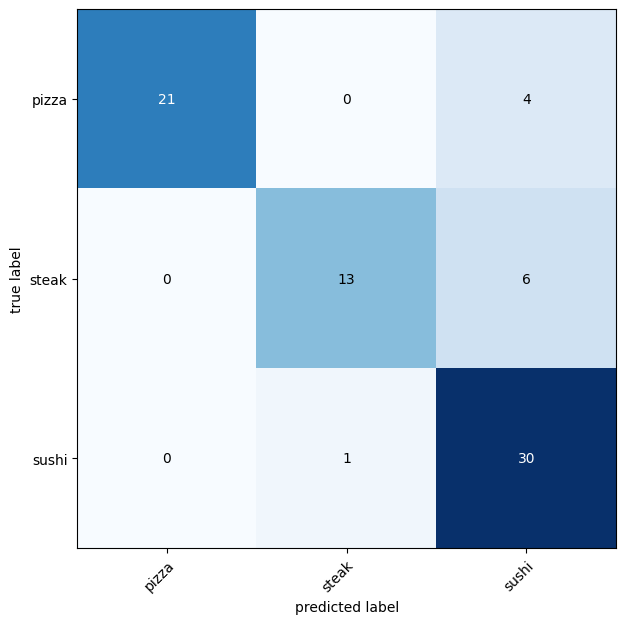

In [39]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat = ConfusionMatrix(num_classes=len(class_names),task='multiclass')
conf_mat_tensor = conf_mat(test_preds,test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7),
    cmap=plt.cm.Blues
)

In [21]:
# TODO: Recreate a new model 


##  Train the model from section above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [41]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data20percent/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data20percent\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(WindowsPath('data20percent/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data20percent/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [42]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [67]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fe6a387950>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [68]:
# TODO
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT

model = torchvision.models.efficientnet_b1(weights=weights)
model.classifier = nn.Sequential(
    
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
    
)

### Train a model with 20% of the data

In [69]:
# TODO
from Python_Modules import data_setup , engine 

In [71]:
results = engine.train(model=model, train_dataloader=train_dataloader_20_percent,test_dataloader=test_dataloader_20_percent,optimizer=optimizer,loss_fn=loss_fn,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:28<04:14, 28.32s/it]

Epoch: 1 | train_loss: 1.1012 | train_acc: 0.3438 | test_loss: 1.1033 | test_acc: 0.3199


 20%|██        | 2/10 [00:57<03:52, 29.02s/it]

Epoch: 2 | train_loss: 1.1102 | train_acc: 0.3146 | test_loss: 1.1053 | test_acc: 0.2892


 30%|███       | 3/10 [01:24<03:16, 28.07s/it]

Epoch: 3 | train_loss: 1.1025 | train_acc: 0.3396 | test_loss: 1.1051 | test_acc: 0.2926


 40%|████      | 4/10 [01:53<02:50, 28.42s/it]

Epoch: 4 | train_loss: 1.1037 | train_acc: 0.3187 | test_loss: 1.1048 | test_acc: 0.2739


 50%|█████     | 5/10 [02:21<02:21, 28.23s/it]

Epoch: 5 | train_loss: 1.1008 | train_acc: 0.3167 | test_loss: 1.1030 | test_acc: 0.3023


 60%|██████    | 6/10 [02:47<01:50, 27.56s/it]

Epoch: 6 | train_loss: 1.1106 | train_acc: 0.3458 | test_loss: 1.1053 | test_acc: 0.2710


 70%|███████   | 7/10 [03:13<01:20, 27.00s/it]

Epoch: 7 | train_loss: 1.1030 | train_acc: 0.3583 | test_loss: 1.1021 | test_acc: 0.3205


 80%|████████  | 8/10 [03:40<00:53, 26.94s/it]

Epoch: 8 | train_loss: 1.1085 | train_acc: 0.2750 | test_loss: 1.1029 | test_acc: 0.2801


 90%|█████████ | 9/10 [04:07<00:26, 26.82s/it]

Epoch: 9 | train_loss: 1.1070 | train_acc: 0.3146 | test_loss: 1.1014 | test_acc: 0.3017


100%|██████████| 10/10 [04:32<00:00, 27.28s/it]

Epoch: 10 | train_loss: 1.1111 | train_acc: 0.2667 | test_loss: 1.1054 | test_acc: 0.2892
